In [1]:
%matplotlib inline


# Training using REINFORCE for Mujoco

<img src="file://_static/img/tutorials/reinforce_invpend_gym_v26_fig1.gif" width="400" alt="agent-environment-diagram">

This tutorial serves 2 purposes:
 1. To understand how to implement REINFORCE [1] from scratch to solve Mujoco's InvertedPendulum-v4
 2. Implementation a deep reinforcement learning algorithm with Gymnasium's v0.26+ `step()` function

We will be using **REINFORCE**, one of the earliest policy gradient methods. Unlike going under the burden of learning a value function first and then deriving a policy out of it,
REINFORCE optimizes the policy directly. In other words, it is trained to maximize the probability of Monte-Carlo returns. More on that later.

**Inverted Pendulum** is Mujoco's cartpole but now powered by the Mujoco physics simulator -
which allows more complex experiments (such as varying the effects of gravity).
This environment involves a cart that can moved linearly, with a pole fixed on it at one end and having another end free.
The cart can be pushed left or right, and the goal is to balance the pole on the top of the cart by applying forces on the cart.
More information on the environment could be found at https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/

**Training Objectives**: To balance the pole (inverted pendulum) on top of the cart

**Actions**: The agent takes a 1D vector for actions. The action space is a continuous ``(action)`` in ``[-3, 3]``,
where action represents the numerical force applied to the cart
(with magnitude representing the amount of force and sign representing the direction)

**Approach**: We use PyTorch to code REINFORCE from scratch to train a Neural Network policy to master Inverted Pendulum.

An explanation of the Gymnasium v0.26+ `Env.step()` function

``env.step(A)`` allows us to take an action 'A' in the current environment 'env'. The environment then executes the action
and returns five variables:

-  ``next_obs``: This is the observation that the agent will receive after taking the action.
-  ``reward``: This is the reward that the agent will receive after taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional information about the environment.


In [2]:
from __future__ import annotations

import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

import gymnasium as gym
from gymnasium.utils.save_video import save_video


plt.rcParams["figure.figsize"] = (10, 5)

## Policy Network

<img src="file://_static/img/tutorials/reinforce_invpend_gym_v26_fig2.png">

We start by building a policy that the agent will learn using REINFORCE.
A policy is a mapping from the current environment observation to a probability distribution of the actions to be taken.
The policy used in the tutorial is parameterized by a neural network. It consists of 2 linear layers that are shared between both the predicted mean and standard deviation.
Further, the single individual linear layers are used to estimate the mean and the standard deviation. ``nn.Tanh`` is used as a non-linearity between the hidden layers.
The following function estimates a mean and standard deviation of a normal distribution from which an action is sampled. Hence it is expected for the policy to learn
appropriate weights to output means and standard deviation based on the current observation.



In [3]:
class Policy_Network(nn.Module):
    """Parametrized Policy Network."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes a neural network that estimates the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """
        super().__init__()

        hidden_space1 = 16  # Nothing special with 16, feel free to change
        hidden_space2 = 32  # Nothing special with 32, feel free to change

        # Shared Network
        self.shared_net = nn.Sequential(
            nn.Linear(obs_space_dims, hidden_space1),
            nn.Tanh(),
            nn.Linear(hidden_space1, hidden_space2),
            nn.Tanh(),
        )

        # Policy Mean specific Linear Layer
        self.policy_mean_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

        # Policy Std Dev specific Linear Layer
        self.policy_stddev_net = nn.Sequential(
            nn.Linear(hidden_space2, action_space_dims)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Conditioned on the observation, returns the mean and standard deviation
         of a normal distribution from which an action is sampled from.

        Args:
            x: Observation from the environment

        Returns:
            action_means: predicted mean of the normal distribution
            action_stddevs: predicted standard deviation of the normal distribution
        """
        shared_features = self.shared_net(x.float())

        action_means = self.policy_mean_net(shared_features)
        action_stddevs = torch.log(
            1 + torch.exp(self.policy_stddev_net(shared_features))
        )

        return action_means, action_stddevs

## Building an agent

<img src="file://_static/img/tutorials/reinforce_invpend_gym_v26_fig3.jpeg">

Now that we are done building the policy, let us develop **REINFORCE** which gives life to the policy network.
The algorithm of REINFORCE could be found above. As mentioned before, REINFORCE aims to maximize the Monte-Carlo returns.

Fun Fact: REINFROCE is an acronym for " 'RE'ward 'I'ncrement 'N'on-negative 'F'actor times 'O'ffset 'R'einforcement times 'C'haracteristic 'E'ligibility

Note: The choice of hyperparameters is to train a decently performing agent. No extensive hyperparameter
tuning was done.




In [4]:
class REINFORCE:
    """REINFORCE algorithm."""

    def __init__(self, obs_space_dims: int, action_space_dims: int):
        """Initializes an agent that learns a policy via REINFORCE algorithm [1]
        to solve the task at hand (Inverted Pendulum v4).

        Args:
            obs_space_dims: Dimension of the observation space
            action_space_dims: Dimension of the action space
        """

        # Hyperparameters
        self.learning_rate = 1e-4  # Learning rate for policy optimization
        self.gamma = 0.99  # Discount factor
        self.eps = 1e-6  # small number for mathematical stability

        self.probs = []  # Stores probability values of the sampled action
        self.rewards = []  # Stores the corresponding rewards

        self.net = Policy_Network(obs_space_dims, action_space_dims)
        self.optimizer = torch.optim.AdamW(self.net.parameters(), lr=self.learning_rate)

    def sample_action(self, state: np.ndarray) -> float:
        """Returns an action, conditioned on the policy and observation.

        Args:
            state: Observation from the environment

        Returns:
            action: Action to be performed
        """
        state = torch.tensor(np.array([state]))
        action_means, action_stddevs = self.net(state)

        # create a normal distribution from the predicted
        #   mean and standard deviation and sample an action
        distrib = Normal(action_means[0] + self.eps, action_stddevs[0] + self.eps)
        action = distrib.sample()
        prob = distrib.log_prob(action)

        action = action.numpy()

        self.probs.append(prob)

        return action

    def update(self):
        """Updates the policy network's weights."""
        running_g = 0
        gs = []

        # Discounted return (backwards) - [::-1] will return an array in reverse
        for R in self.rewards[::-1]:
            running_g = R + self.gamma * running_g
            gs.insert(0, running_g)

        deltas = torch.tensor(gs)

        loss = 0
        # minimize -1 * prob * reward obtained
        for log_prob, delta in zip(self.probs, deltas):
            loss += log_prob.mean() * delta * (-1)

        # Update the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Empty / zero out all episode-centric/related variables
        self.probs = []
        self.rewards = []

Now lets train the policy using REINFORCE to master the task of Inverted Pendulum.

Following is the overview of the training procedure

   for seed in random seeds
       reinitialize agent

       for episode in range of max number of episodes
           until episode is done
               sample action based on current observation

               take action and receive reward and next observation

               store action take, its probability, and the observed reward
           update the policy

Note: Deep RL is fairly brittle concerning random seed in a lot of common use cases (https://spinningup.openai.com/en/latest/spinningup/spinningup.html).
Hence it is important to test out various seeds, which we will be doing.



In [ ]:
# Create and wrap the environment
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array_list")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward

total_num_episodes = int(5e4)  # Total number of episodes
# Observation-space of InvertedPendulum-v4 (4)
obs_space_dims = env.observation_space.shape[0]
# Action-space of InvertedPendulum-v4 (1)
action_space_dims = env.action_space.shape[0]
rewards_over_seeds = []

for seed in [5]:  # Fibonacci seeds
    # set seed
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reinitialize agent every seed
    agent = REINFORCE(obs_space_dims, action_space_dims)
    reward_over_episodes = []

    for episode in range(total_num_episodes):
        # gymnasium v26 requires users to set seed while resetting the environment
        obs, info = wrapped_env.reset(seed=seed)

        done = False
        while not done:
            action = agent.sample_action(obs)

            # Step return type - `tuple[ObsType, SupportsFloat, bool, bool, dict[str, Any]]`
            # These represent the next observation, the reward from the step,
            # if the episode is terminated, if the episode is truncated and
            # additional info from the step
            obs, reward, terminated, truncated, info = wrapped_env.step(action)
            agent.rewards.append(reward)

            # End the episode when either truncated or terminated is true
            #  - truncated: The episode duration reaches max number of timesteps
            #  - terminated: Any of the state space values is no longer finite.
            done = terminated or truncated        

        reward_over_episodes.append(wrapped_env.return_queue[-1])
        agent.update()

        if episode % 1000 == 0:
            avg_reward = int(np.mean(wrapped_env.return_queue))
            print("Episode:", episode, "Average Reward:", avg_reward)
            save_video(
                wrapped_env.render(), 
                f"Video_{seed}_{episode}_{avg_reward}",
                fps=env.metadata["render_fps"],
            )            

    rewards_over_seeds.append(reward_over_episodes)

## Plot learning curve




In [17]:
rewards_to_plot = [[reward[0] for reward in rewards] for rewards in rewards_over_seeds]
df1 = pd.DataFrame(rewards_to_plot).melt()
df1.rename(columns={"variable": "episodes", "value": "reward"}, inplace=True)
df1.head(100)

,episodes,reward
0,0,5.0
1,0,10.0
2,1,6.0
3,1,5.0
4,2,8.0
...,...,...
95,47,17.0
96,48,8.0
97,48,6.0
98,49,13.0


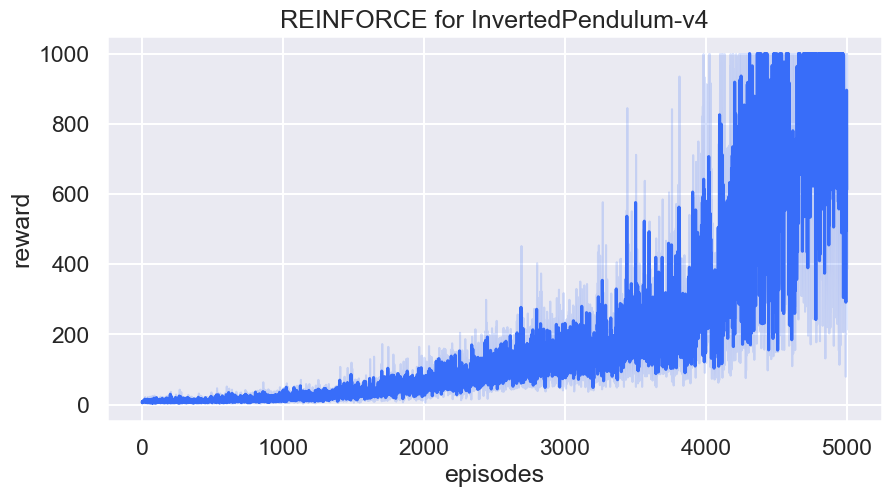

In [18]:
sns.set(style="darkgrid", context="talk", palette="rainbow")
sns.lineplot(x="episodes", y="reward", data=df1).set(
    title="REINFORCE for InvertedPendulum-v4"
)
plt.show()

<img src="file://_static/img/tutorials/reinforce_invpend_gym_v26_fig4.png">

Author: Siddarth Chandrasekar

License: MIT License

## References

[1] Williams, Ronald J.. “Simple statistical gradient-following
algorithms for connectionist reinforcement learning.” Machine Learning 8
(2004): 229-256.


